Content-aware image resizing with seam carving

In [5]:
import numpy as np
from skimage.transform import (hough_line, hough_line_peaks, hough_circle,
hough_circle_peaks)
from skimage.draw import circle_perimeter
from skimage.feature import canny
from skimage.data import astronaut
from skimage.io import imread, imsave
from skimage.color import rgb2gray, gray2rgb, label2rgb
from skimage import img_as_float
from skimage.morphology import skeletonize
from skimage import data, img_as_float
import matplotlib.pyplot as pylab
from matplotlib import cm
from skimage.filters import sobel, threshold_otsu
from skimage.feature import canny
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries, find_boundaries

Original Image Shape: (720, 534, 3)
Resized Image Shape: (720, 334, 3)


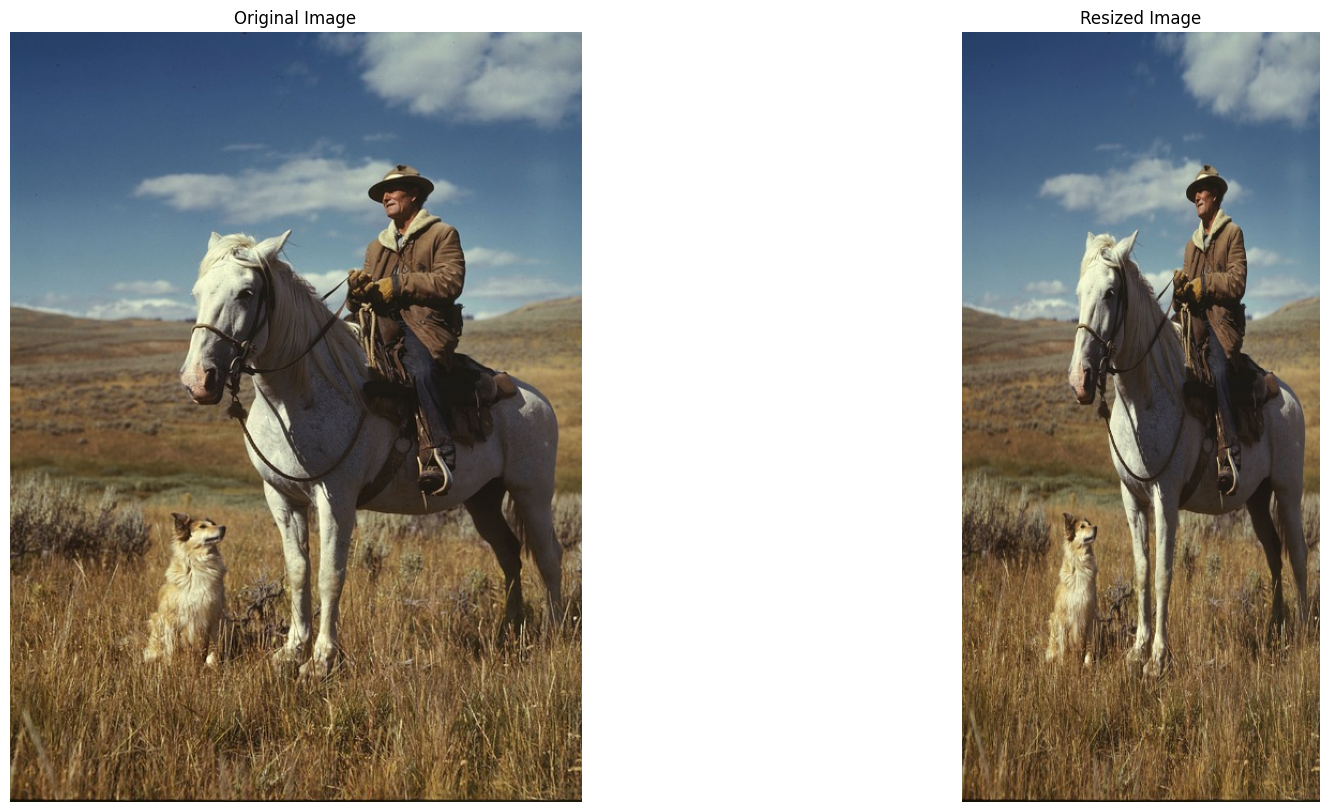

In [12]:
import numpy as np
from skimage import transform, util, filters, color
from skimage.io import imread
import matplotlib.pyplot as plt

# Bước 1: Đọc ảnh
image = imread('./images/man.jpg')
print("Original Image Shape:", image.shape)

# Chuyển đổi ảnh về dạng float để xử lý
image = util.img_as_float(image)

# Bước 2: Tính năng lượng ảnh
energy_image = filters.sobel(color.rgb2gray(image))

# Bước 3: Áp dụng Seam Carving - giảm chiều rộng 200 pixel
resized = transform.resize(
    image, (image.shape[0], image.shape[1] - 200), mode='reflect'
)
print("Resized Image Shape:", resized.shape)

# Bước 4: Hiển thị cả hai ảnh cạnh nhau
plt.figure(figsize=(20, 10))

# Ảnh gốc
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

# Ảnh sau khi Resize
plt.subplot(1, 2, 2)
plt.title('Resized Image')
plt.imshow(resized)
plt.axis('off')

plt.show()


Object removal with seam carving

(720, 534, 3)


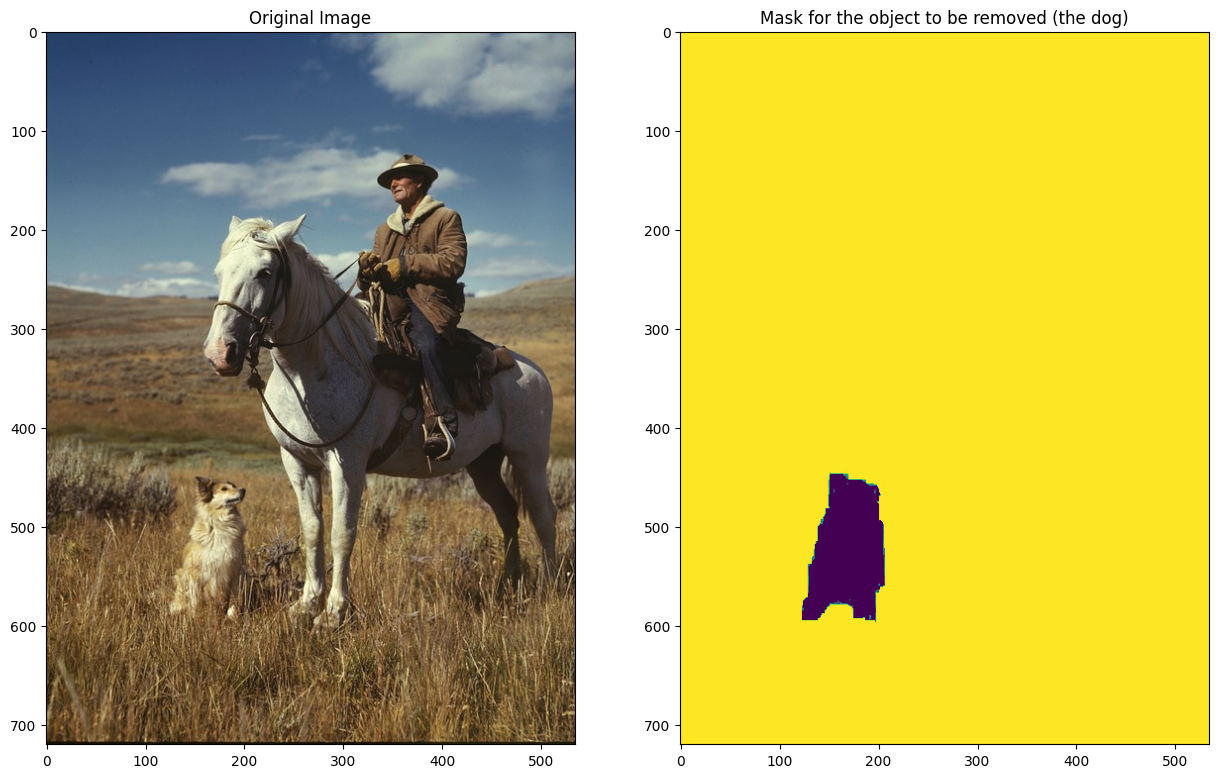

In [14]:
image = imread('./images/man.jpg')
mask_img = rgb2gray(imread('./images/man_mask.jpg'))
print(image.shape)
pylab.figure(figsize=(15,10))
pylab.subplot(121), pylab.imshow(image), pylab.title('Original Image')
pylab.subplot(122), pylab.imshow(mask_img), pylab.title('Mask for the object to be removed (the dog)') 
pylab.show()

ValueError: zero-size array to reduction operation minimum which has no identity

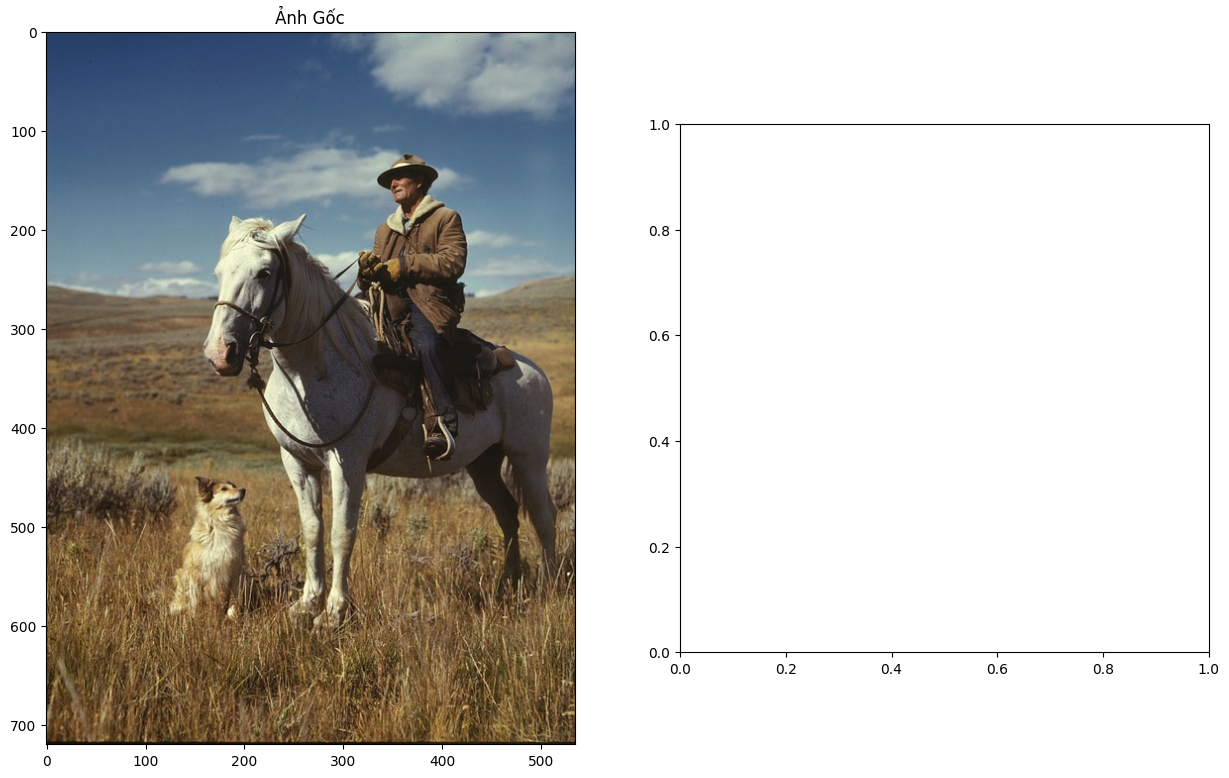

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage import filters, util, img_as_float

# Đọc ảnh và mask
image = imread('./images/man.jpg')
mask_img = (rgb2gray(imread('./images/man_mask.jpg')) > 0.5).astype(bool)
 # Mask dạng nhị phân

image = img_as_float(image)

def compute_energy(image):
    """ Tính năng lượng bằng bộ lọc Sobel """
    gray_image = rgb2gray(image)
    return filters.sobel(gray_image)

def find_vertical_seam(energy, mask):
    """ Tìm seam dọc có năng lượng thấp nhất """
    rows, cols = energy.shape
    seam_map = np.copy(energy)
    seam_map[mask.astype(bool)] -= 1000


    backtrack = np.zeros_like(seam_map, dtype=int)

    for row in range(1, rows):
        for col in range(cols):
            left = seam_map[row - 1, col - 1] if col > 0 else float('inf')
            up = seam_map[row - 1, col]
            right = seam_map[row - 1, col + 1] if col < cols - 1 else float('inf')

            min_energy = min(left, up, right)
            seam_map[row, col] += min_energy

            if min_energy == left:
                backtrack[row, col] = col - 1
            elif min_energy == up:
                backtrack[row, col] = col
            else:
                backtrack[row, col] = col + 1

    seam = np.zeros(rows, dtype=int)
    seam[-1] = np.argmin(seam_map[-1])

    for row in range(rows - 2, -1, -1):
        seam[row] = backtrack[row + 1, seam[row + 1]]

    return seam

def remove_vertical_seam(image, seam):
    """ Loại bỏ seam dọc khỏi ảnh """
    rows, cols, channels = image.shape
    new_image = np.zeros((rows, cols - 1, channels), dtype=float)

    for row in range(rows):
        col = seam[row]
        new_image[row, :, :] = np.delete(image[row, :, :], col, axis=0)

    return new_image

def remove_seam_until_object_removed(image, mask):
    """ Lặp lại quá trình loại bỏ seam cho đến khi đối tượng biến mất """
    while np.any(mask):
        energy = compute_energy(image)
        seam = find_vertical_seam(energy, mask)
        image = remove_vertical_seam(image, seam)
        mask = remove_vertical_seam(mask[:, :, np.newaxis], seam)[:, :, 0]
    return image

# Loại bỏ đối tượng trong ảnh
output_image = remove_seam_until_object_removed(image, mask_img)

# Hiển thị kết quả
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Ảnh Gốc")

plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title("Ảnh Sau Khi Loại Bỏ Đối Tượng")

plt.show()
